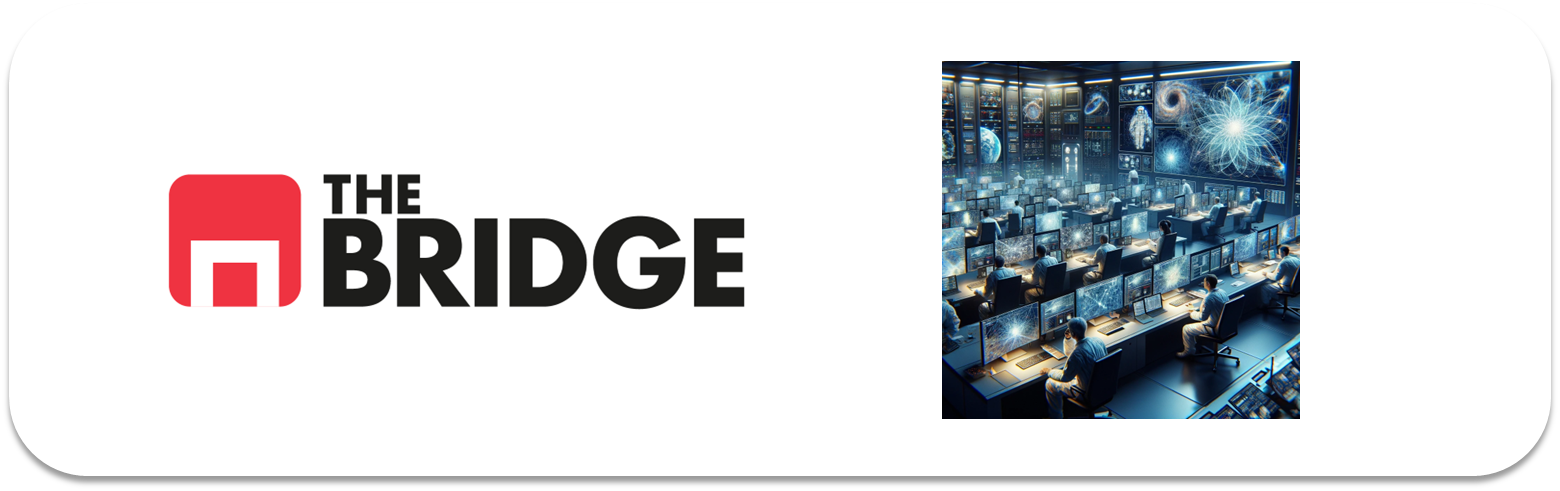

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/'
train_dir = os.path.join(base_dir, 'seg_train')
pred_dir = os.path.join(base_dir, 'seg_pred')
test_dir = os.path.join(base_dir, 'seg_test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # rotación aleatoria entre 0 y 20 grados
    width_shift_range=0.2,   # desplazamiento horizontal
    height_shift_range=0.2,  # desplazamiento vertical
    shear_range=0.2,         # transformaciones de corte
    zoom_range=0.2,          # zoom
    horizontal_flip=True,    # voltea horizontalmente
    fill_mode='nearest'      # rellena los píxeles vacíos resultantes de los shifts
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

pred_generator = val_datagen.flow_from_directory(
    pred_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 14034 images belonging to 1 classes.
Found 7301 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


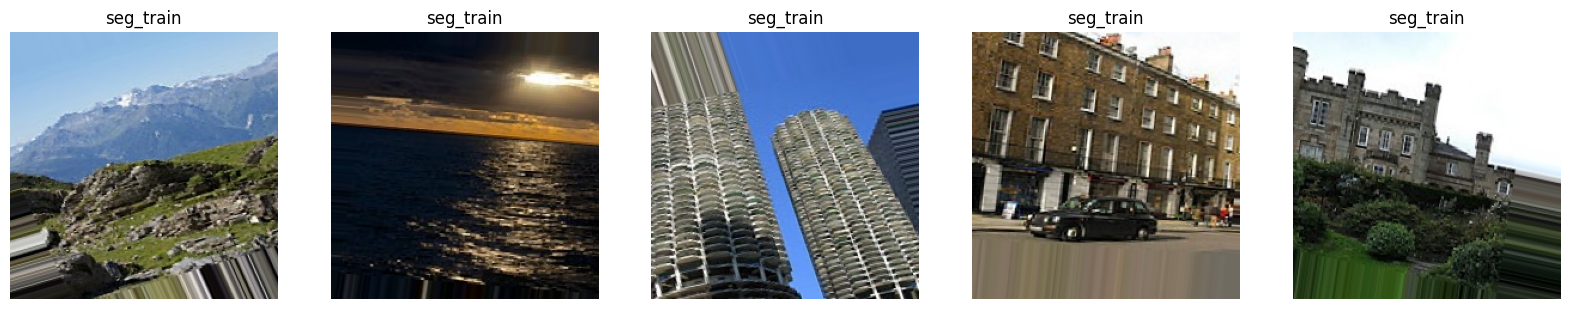

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    axes[i].imshow(x_batch[i])
    class_index = np.argmax(y_batch[i])
    class_label = list(train_generator.class_indices.keys())[class_index]
    axes[i].set_title(class_label)
    axes[i].axis('off')
plt.show()


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [10]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,                  # Modelo base (congelado)
    layers.Flatten(),            # Aplanamos la salida
    layers.Dense(256, activation='relu'),  
    layers.Dropout(0.5),         # Regularización
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()  


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,315,331 (69.87 MB)

 Trainable params: 16,057,347 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
history = model.fit(
    train_generator,
    epochs=...,
    validation_data=pred_generator
)


c:\Users\lukat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


TypeError: 'ellipsis' object cannot be interpreted as an integer

In [13]:
test_loss, test_acc = model.evaluate(test_generator)


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 3)